# Clasificación de preguntas de clientes: Informe de la competencia Meta:Data


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Obtenemos los archivos de train y test 
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl' -O training.csv # Ver https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bsV_URfRHy8LNLA1SKJ24hv0lRNVXMV4' -O test.csv

--2020-07-16 18:37:47--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2020-07-16 18:37:47--  https://docs.google.com/uc?export=download&id=1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl
Resolving docs.google.com (docs.google.com)... 64.233.167.102, 64.233.167.139, 64.233.167.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.167.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/duj4vbj7t09d5qfbs49dr9857t8k02n4/1594924650000/02566007216604018568/*/1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl?e=download [following]
--2020-07-16 18:37:48--  https://doc-00-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/duj4vbj7t09d5qfbs49dr9857t8k02n4/1594924650000/02566007216604018568/*/1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl?e=download
Resolving doc-00-b0-docs.googleusercontent.com (d

## Resumen



El presente documento es un breve informe sobre la metodología utilizada en la competencia *(Meta:Data) Clasificación de preguntas de clientes*. El objetivo del mismo fue diseñar un modelo que clasifique correctamente preguntas de clientes de un banco, las cuales podían pertenecer a un conjunto de 350 posibles categorías aproximadamente. El modelo utilizado que mejor resultado obtuvo fue una versión pre-entrenada del transformer BETO (también conocido como "spanish BERT"). Partiendo de esta versión, se realizó un ajuste fino (*fine-tuning*) con los datos provistos a los competidores, obteniendo un puntaje público de 0.85849 *balanced accuracy*. Previamente se probaron modelos de menor desempeño, tales como Naive Bayes y SVM, de los cuales se hará mención al final del informe.

# Descripción de la tarea y análisis exploratorio de los datos

La competencia consistió en clasificar preguntas de clientes del banco Santander. Cada pregunta podía pertenecer a exactamente una categoría, entre 350 posibles aproximadamente. A continuación observamos algunas de las muestras del archivo `training.csv` a modo de ejemplo, y un histograma por categoría de todo el conjunto de entrenamiento.

In [ ]:
# Cargamos el dataset:
df = pd.read_csv('training.csv',sep = '|')

# Convertimos a int las etiquetas:
df['Intencion'] = df['Intencion'].str.findall(r'\d+').apply(lambda x: int(x[0]))

# Visualizamos algunos ejemplos:
df.head(5)

,Pregunta,Intencion
0,como puedo trabajar en santander rio,102
1,pagar tarjeta visa querer reintegro,350
2,pagar tarjeta naranja sistema,132
3,no se debitó la primera cuota del plan de bien...,129
4,abonar tarjeta credito,342


Categoría más alta: 359
Categoría más baja: 0
Cantidad de categorías: 352


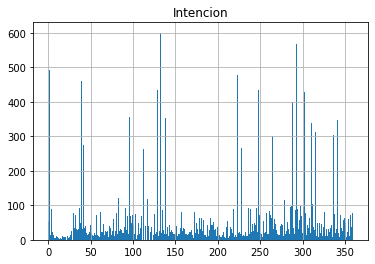

In [ ]:
# Visualizamos el histograma por categoría:
lowest_category = df['Intencion'].min() 
highest_category = df['Intencion'].max()
bins_num = highest_category-lowest_category+1
df.hist(bins=bins_num)

# Categoría más alta y más baja:
uniques_values = df['Intencion'].unique()
print('Categoría más alta:',max(uniques_values))
print('Categoría más baja:',min(uniques_values))
print('Cantidad de categorías:',len(uniques_values))

Puede observarse, en primer lugar, que se trata de un dataset con categorías desbalanceadas, ya que hay categorías con más de 400 ejemplos y categorías con menos de 10. Además, dado que la cantidad total de categorías no es la misma que la diferencia entre la categoría más alta y la más baja, podemos inferir que hay clases que no contienen ejemplos:

In [ ]:
counts, _ = np.histogram(df['Intencion'].values, bins=bins_num)
print('Menor cantidad de ejemplos en una categoría entre la máxima y la mínima:', min(counts))

Menor cantidad de ejemplos en una categoría entre la máxima y la mínima: 0


Uno de los análisis realizados en el presente trabajo fue considerar diferentes conjuntos de posibles categorías. Es decir, por un lado se realizaron experimentos considerando que las categorías posibles eran las que aparecían en el conjunto de entrenamiento, y por el otro, experimentos en los que cualquier categoría entre 0 y 359 podía aparecer en el conjunto de validación. Dado que la segunda opción presentó mejores resultados que la primera, de aquí en adelante se presentará el análisis para 360 categorías posibles (de 0 a 359). Si bien suponemos que esto puede deberse a que el modelo define mejor sus regiones de decisión cuando se tiene esta cantidad de categorías, debería hacerse un análisis más exhaustivo para comprobar esta hipótesis, lo cual excede los objetivos de la competencia.

Por otra parte, se buscaron algunos métodos para lidiar con el problema de clases desbalanceadas. Comúnnmente ([Coulombe, 2018](https://arxiv.org/abs/1812.04718); [Wei et al. 2019](https://arxiv.org/abs/1901.11196)), estos suelen incluír procesos de aumento de los datos (*data augmentation*) como:
* Repetición de las muestras pertenecientes a clases con pocos ejemplos
* Aumento sintético de datos a partir de fuentes léxicas, diccionarios, etc. 
* Traducción a otros idiomas con más recursos.
* Conseguir más datos de otras fuentes.

Dado que no se encontró otra fuente pública de datos similares, el conjunto de datos se limitó a los datos disponibles. Además, las pruebas realizadas con los tres primeros métodos tampoco presentaron mejoras en los resultados mostrados más adelante. 

Otra idea (esta vez, original) que se probó, fue generar nuevas muestras de entrenamiento uniendo frases de la misma clase en una sola muestra. Por ejemplo, si las oraciones "pasar pregunta seguridad" e "intentar poder obtener clave" pertenecen a la misma categoría, se genera una nueva muestra para esa categoría con la oración "pasar pregunta seguridad intentar poder obtener clave". Sin embargo, los mejores resultados fueron obtenidos para cuando el conjunto de entrenamiento era el original.

# Descripción del modelo utilizado

En esta sección describimos el modelo utilizado en la competencia que mejor resultados presentó. Este modelo se conoce como [BETO](https://github.com/dccuchile/beto) o Spanish BERT, que es una versión en español del transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html).

## *Transformers*

En 2017 el equipo de Google Brain publicó en el trabajo titulado "*Attention is all you need*" ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)) una nueva arquitectura para realizar tareas de NLP que involucran procesamiento de secuencias, basada principalmente en mecanismos de atención. Esta arquitectura, conocida como *Transformer*, dio origen a un nuevo enfoque en el diseño de modelos para procesar secuencias de texto, que permiten pre-entrenar modelos de lenguaje a partir de texto no supervisado en menor tiempo que los modelos basados en redes recurrentes (RNN, LSTM, GRU, etc.) y muchas veces, con mejores resultados. 

Siguiendo con esta línea de trabajo, en los últimos años se desarrollaron nuevos modelos de tipo *Transformer* que presentan resultados de estado del arte en tareas como traduccióna automática (*Machine translation*), pregunta-respuesta (*Question-answering*), inferencia de lenguaje natural (*Natural Language Inference, NLI*) o clasificación de texto, entre otras. Entre los modelos más importantes publicados hasta el momento se encuentran ELMo ([Peters et al., 2018a](https://arxiv.org/abs/1802.05365)), OpenAI GTP ([Radford et al. 2018](https://pdfs.semanticscholar.org/cd18/800a0fe0b668a1cc19f2ec95b5003d0a5035.pdf?_ga=2.221006872.1028894270.1594655163-1725152514.1590450085)) y BERT ([Devlin et al., 2018](https://arxiv.org/abs/1810.04805)). 

Si bien estos modelos fueron entrenados para realizar tareas en idioma inglés, en los últimos meses ha habido un gran desarrollo de variantes sobre estos modelos, a lenguajes específicos. Un ejemplo de esto es BETO ([Cañete et al., 2020](https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf)), que utiliza la misma arquitectura que el modelo BERT y fue entrenada con un corpus totalmente en español de libre acceso ([Spanish Unannotated Corpora](https://github.com/josecannete/spanish-corpora)). 

A continuación describimos el proceso de uso del modelo BETO, que fue el utilizado para resolver la tarea propuesta en la competencia, así como también todo lo necesario para reproducir los resultados obtenidos.

## BETO



El modelo BERT (*Bidirectional Encoder Representations from
Transformers*) fue introducido por [Devlin et al.](https://arxiv.org/abs/1810.04805) en 2018 como un nuevo modelo capaz de representar secuencias de texto, a partir de un entrenamiento con texto no supervisado. Esta representación, a diferencia de los modelos anteriores a BERT, se realizaba mediante una estructura bidireccional, lo cual permite incluir información de toda la secuencia a la vez, argumentando que el modelo incrementaría el rendimiento en tareas como NLI o pregunta-respuesta.

## Modo de uso

Este modelo fue pensado para ser preentrenado con un conjunto muy grande de secuencias de texto no supervisadas, y utilizado posteriormente en una tarea específica (como clasificación, NLI, NER, etc.) a través de un ajuste fino (*fine-tuning*) de los parámetros del modelo. Más específicamente, en el primer paso se entrena un autoencoder bidireccional realizando un modelo de lenguaje "enmascarado" (técnica conocida como *masking*) con un corpus de entrenamiento no supervisado muy extenso. Por otro lado, en la segunda parte del entrenamiento se utiliza el encoder entrenado anteriormente para codificar secuencia de texto de entrada (la pregunta del cliente) e ingresarla a una capa que devuelve la salida necesaria (la probabilidad de pertenecer a cada categoría). Como en este caso se clasificarán preguntas, el decoder consiste únicamente en una capa lineal con salida softmax. En esta segunda parte del entrenamiento, se reentrenan todos los parámetros del modelo a la vez, incluídos los del encoder. Este proceso se conoce como *fine-tuning*.

![alt text](https://www.gabormelli.com/RKB/images/thumb/8/89/2018_BERTPreTrainingofDeepBidirectio_Fig1b.png/700px-2018_BERTPreTrainingofDeepBidirectio_Fig1b.png)

Siguiendo esta metodología, el procedimiento seguido a lo largo de todos los experimentos fue el siguiente:

1. Utilizar el modelo BETO, que consiste en el encoder BERT pre-entrenado para idioma español con el corpus de libre acceso [Spanish Unannotated Corpora](https://github.com/josecannete/spanish-corpora).
2. Reemplazar la capa final del modelo por una capa lineal con salida *softmax* y realizar un ajuste fino de todos los parámetros del modelo con los datos provistos en el archivo `training.csv`, eligiendo para ello la función de costo [Cross-Entropy](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html).


## Arquitectura del modelo

Como se dijo antes, la arquitectura del modelo que clasifica las preguntas de los clientes consiste en un encoder pre-entrenado y una salida lineal con activación softmax. El modelo se entrena con todas las muestras del archivo `training.csv` y se utiliza una función de costo `Cross-Entropy`.

El encoder BERT corresponde a una arquitectura transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), la cual consiste en una cantidad de capas conectadas secuencialmente que combinan mecanismos de múltiple-autoatención aditiva (*additive Multi-head self-attention*) ([Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473)), capas de normalización, capas *feed-forward* y, generalmente, algún tipo de regularización como *dropout*. 

![alt text](https://d3i71xaburhd42.cloudfront.net/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035/4-Figure1-1.png)

Además, la arquitectura contiene un layer inicial que convierte los índices de la secuencia que ingresa a la red en *word embeddings* ([Turial et al.,2010](https://www.aclweb.org/anthology/P10-1040/)), que a su vez son combinados con vectores posicionales ([Gehring et al.,2017](https://arxiv.org/abs/1705.03122)). La estructura bidireccional, característica del modelo BERT, se basa en relacionar mediante los mecanismos de autoatención todos los vectores que componen las palabras de la secuencia al mismo tiempo. 

De esta manera, los hiperparámetros de la arquitectura son:

* El tamaño del vocabulario.

* La dimensión de los *word embeddings* y *positional embeddings*.

* La cantidad de capas del transformer

* La multiplicidad de los mecanismos de atención (es decir, la cantidad de "cabezas" (*heads*) de las capas de de multiatención).

* Las dimensiones de las capas *feed-forward* de cada capa y el tipo de activación entre ellas.

* La probabilidad de *dropout*, tanto dentro de cada capa como a la salida de cada una de ellas.

Si bien parece haber muchos hiperparámetros para modificar, en la versión preentrenada BETO los hiperparámetros se reducen a la probabilidad de *dropout* y las activaciones entre las capas del transformer, puesto que la determinación de los hiperparámetros se hace en el momento de entrenar el encoder, no en el ajuste fino. El modelo preentrenado conteniene:

* un vocabulario de 31002 tokens,
* *word vectors* de dimensión 768,
* 12 cabezas de atención en cada capa de autoatención,
* dos capas *feed-forward* en cada capa transformer con 3072 neuronas ocultas en el medio de ellas y
* 12 capas transformer como las descritas anteriormente.

## Elección del modelo

Este procedimiento fue elegido principalmente debido los buenos resultados que demostraron tener los transformers para este tipo de tareas, sumado a la disponibilidad de un modelo preentrenado de BERT en idioma español. Además, la poca disponibilidad de recursos que se tenía para entrenar modelos que resuelvan correctamente este tipo de tareas hizo que se optara por una arquitectura con mecanismos de atención a una recurrente, debido a su capacidad de paralelizar operaciones.

Es importante destacar que la mayoría de los modelos son pre-entrenados para resolver tareas en idioma inglés, por lo que el resultado de aplicar modelos entrenados en este idioma a tareas en español no es muy bueno. Por eso, el hecho de haber encontrado un modelo preentrenado en español resulta muy atractivo de aplicar en este tipo de tareas.

Por otro lado, existen trabajos ([Pires et al., 2019](https://arxiv.org/abs/1906.01502); [Conneau et al., 2020](https://arxiv.org/pdf/1911.02116.pdf)) en los que se entrena al modelo con varios idiomas a la vez y se evalua en tareas multilingües. Si bien esto podría haber resultado prometedor, el mejor resultado que hemos obtenido para el problema de clasificación de preguntas fue utilizando el modelo BETO ([Cañete et al., 2020](https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf)) disponible en [este](https://github.com/dccuchile/beto) hipervínculo.

Además, durante el desarrollo de este trabajo, otros modelos similares a BETO fueron probados siguiendo este procedimiento. Algunos de ellos fueron:

* XLM-RoBERTa [(Conneau et al., 2019)](https://arxiv.org/abs/1911.02116): Modelo multilingüe basado en RoBERTa [Liu et al., 2019](https://arxiv.org/abs/1907.11692), una versión optimizada de BERT.

* DistilBERT [(Sanh et al., 2019)](https://arxiv.org/abs/1910.01108): versión "liviana" del modelo BERT, es decir, con menos parámetros y performance similar. Se encontró una versión libre preentrenada para clasificación y otra para resolver problemas de pregunta-respuesta en la librería [transformers](https://github.com/huggingface/transformers) de este modelo

Sin embargo, BETO presentó mejores resultados que estos modelos.

## Implementación por la librería Transformers

La librería [transformers](https://github.com/huggingface/transformers) provee una cómoda implementación en Pytorch y Tensorflow 2.0 de muchos de los modelos mencionados anteriormente. En particular se pudo acceder al modelo BETO a través de esta librería, y utlizarlo para clasificar preguntas de clientes del banco. A continuación se muestra un breve ejemplo de uso de esta librería, extraido de [este](https://colab.research.google.com/drive/1uRwg4UmPgYIqGYY4gW_Nsw9782GFJbPt) notebook. 



In [ ]:
!pip install transformers

En este ejemplo se utiliza el modelo BETO para predecir palabras faltantes de una frase. Es decir, una vez tokenizada la oración, se reemplazan algunas palabras de la misma por el token `[MASK]` y se deja que el modelo prediga la palabra faltante. En el ejemplo la oración es procesada automáticamente por el *tokenizer* pre-entrenado del modelo BETO, el cual ya contiene el vocabulario del modelo y las intrucciones para convertir la secuencia de caracteres en una secuencia de índices. Más adelante se dan detalles sobre el preprocesamiento de las oraciones.

In [ ]:
from transformers import BertForMaskedLM, BertTokenizer

# Obtenemos el tokenizer
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=False)

# Obtenemos el modelo
model = BertForMaskedLM.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model.eval()

Some weights of BertForMaskedLM were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
# Frase de ejemplo
text = "[CLS] no me atiende por [MASK] y quiero dar de baja la [MASK] de credito [SEP]"
# Frase original: "no me atiende por teléfono y quiero dar de baja la tarjeta de crédito"


# Índices de frase a predecir
masked_indxs = (3,5,12)

# Tokenizamos y convertimos a índices del vocabulario
tokens = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
tokens_tensor = torch.tensor([indexed_tokens])
print(tokens)

# Predecimos las palabras enmascaradas con el modelo
predictions = model(tokens_tensor)[0]

# Visualizamos los resultados
for i,midx in enumerate(masked_indxs):
    idxs = torch.argsort(predictions[0,midx], descending=True)
    predicted_token = tokenizer.convert_ids_to_tokens(idxs[:5])
    print('MASK',i,':',predicted_token)

['[CLS]', 'no', 'me', 'atiende', 'por', '[MASK]', 'y', 'quiero', 'dar', 'de', 'baja', 'la', '[MASK]', 'de', 'credi', '##to', '[SEP]']
MASK 0 : ['atiende', 'responde', 'contesta', 'atender', 'recibe']
MASK 1 : ['telefono', 'que', 'hora', 'dia', 'nada']
MASK 2 : ['tarjeta', 'linea', 'cuenta', 'caja', 'factura']


Puede intuírse una gran capacidad de predicción de este modelo a partir del ejemplo anterior observando que, a pesar de que la frase contiene palabras faltantes, la predicción en 3 casos distintos es acertada.

# Clasificación de preguntas de clientes

En esta sección mostramos el código utilizado para resolver el problema planteado en la competencia.



In [ ]:
# Sitio para descargar el modelo BETO
beto_source = 'dccuchile/bert-base-spanish-wwm-uncased'

El primer paso es procesar las preguntas de los clientes de manera que ingresen al modelo como índices de tokens en un vocabulario. Para ello se utilizó la clase `BertTokenizer` de la librería transformers, la cual contiene el vocabulario utilizado por el modelo BERT y a qué token corresponde cada índice. 

Una característica importante de este modelo es que el vocabulario contiene únicamente 31000 tokens distintos, que es un número bastante bajo para un vocabulario. Esto es así porque BERT hace uso de la información de las "subpalabras" (*sub-words*) presentes en el corpus a través del algoritmo de tokenización WordPiece ([Wu et al.,2016](https://arxiv.org/abs/1609.08144)). Es decir, cuando el modelo encuentra una palabra que no está en el vocabulario, trata de dividirla en tokens que sí pertenecen a él. Si esto no es posible, la palabra es tokenizada como `[UNK]`. Esto permite tener un vocabulario menos extenso y hacer uso de la composición semántica interna de la palabra, lo cual muchas veces produce mejores resultados a nivel representación léxica de la oración completa.

In [ ]:
from transformers import BertTokenizer

# Tokenización:
questions = ["[CLS] {} [SEP]".format(question) for question in df['Pregunta']]
tokenizer = BertTokenizer.from_pretrained(beto_source, do_lower_case=False)
tokenized_questions = [tokenizer.tokenize(question) for question in questions]

# Ejemplo:
sample_question_idx = 4
print('Pregunta original:', df['Pregunta'].iloc[sample_question_idx])
print('Pregunta tokenizada:', tokenized_questions[sample_question_idx])

Pregunta original: abonar tarjeta credito
Pregunta tokenizada: ['[CLS]', 'abon', '##ar', 'tarjeta', 'credi', '##to', '[SEP]']


Para reconocer el comienzo y la finalización de una oración, BERT utiliza los tokens especiales `[CLS]` y `[SEP]`, que deben ser agregados manualmente. 

En el ejemplo puede observarse que, como se anticipó previamente, algunas palabras como "abonar" y "credito" fueron divididas en subpalabras y que, de esta manera, se tiene acceso a una división más razonable de los "bloques de significado" de la oración. Es decir que el significado de "abonar" reside mayormente en su raíz "abon", y no en su desinencia "ar" (que es igual para todos los verbos regulares de primera conjugación), y el modelo es capaz de capturar eso.

Una vez tokenizadas las oraciones, es necesario llevarlas a todas a la misma longitud por alguna forma de *padding*. Con esto es posible implementar algún tipo de algoritmo de gradiente estocástico, calculado a partir de un *batch* de muestras.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding de las oraciones:
max_len = 128 # Longitud máxima de las oraciones
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(question) for question in tokenized_questions],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")

Además de la tokenización y el padding, es necesario definir una estructura que diferencie los índices que son pads, de los que son parte de la oración. Para eso se define una [máscara de atención](https://huggingface.co/transformers/glossary.html#attention-mask) para cada secuencia, la cual consiste simplemente en un vector del tamaño de la máxima secuencia que contiene unos en los índices que corresponden con la oración y ceros en los índices que corresponden con los pads.

In [ ]:
# Máscaras de atención:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

sample_question_idx = 4
print('Pregunta original:', df['Pregunta'].iloc[sample_question_idx])
print('Pregunta tokenizada:', tokenized_questions[sample_question_idx])
print('Índices con padding:', input_ids[sample_question_idx])
print('Máscara de atención:',attention_masks[sample_question_idx])

Pregunta original: abonar tarjeta credito
Pregunta tokenizada: ['[CLS]', 'abon', '##ar', 'tarjeta', 'credi', '##to', '[SEP]']
Índices con padding: [    4 19555  1020  6860 13515  1049     5     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Máscara de atención: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0

El entrenamiento se hará en [Pytorch](https://pytorch.org/) a través de la librería [transformers](https://huggingface.co/transformers/index.html), por lo que será necesario convertir las estructuras definidas anterormente en los contenedores de datos que reciben estas librerías para entrenar. Estas son, escencialmente, las estructuras `Dataset` y `DataLoader`.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Índices de las oraciones:
train_inputs = torch.tensor(input_ids)

# Etiquetas:
labels = df['Intencion'].values
train_labels = torch.tensor(labels)

# Máscaras de atención:
train_masks = torch.tensor(attention_masks)

# Dataset:
train_data = TensorDataset(train_inputs, train_masks, train_labels)

# Dataloader:
batch_size = 32
train_sampler = RandomSampler(train_data) # Esto permuta aleatoriamente las muestras de entrenamiento
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

**NOTA IMPORTANTE**: En la presente competencia se dispuso de un conjunto de muestras de entrenamiento supervisado en el archivo `training.csv` y un conjunto de oraciones sin sus etiquetas en el archivo `test.csv`. Dado que es posible obtener un puntaje público con las predicciones del modelo sobre el archivo `test.csv`, se decidió utilizar el conjunto de datos de este archivo como conjunto de validación del modelo. Esto se hizo con el objetivo de dejar la mayor cantidad de muestras para entrenamiento. En una situación diferente a ésta, sin embargo, se tendría que definir obligatoriamente un conjunto de validación a partir de las muestras de entrenamiento y validar las predicciones del modelo con este conjunto, para luego (una vez entrenado y ajustado los hiperparámetros del modelo) predecir sobre el conjunto de test.

Una vez procesadas las muestras, obtenemos el modelo preentrenado con ayuda de las funciones de la librería `transformers`:

In [ ]:
from transformers import BertConfig, BertForSequenceClassification

# Configuración del modelo para obtener el modelo preentrenado
num_labels = max(labels) + 1
config = BertConfig(vocab_size=31002, # Tamaño del vocabulario
                    hidden_size=768, # Dimensión de los word embeddings
                    num_hidden_layers=12, # Cantidad de capas del transformer
                    num_attention_heads=12, # Cantidad de cabezas de atención por capa
                    intermediate_size=3072, # Dimensión intermedia de las capas lineales
                    hidden_act='gelu',  # Activación intermedia entre las capas lineales
                    hidden_dropout_prob=0.1, # Dropout entre las capas lineales
                    attention_probs_dropout_prob=0.1, # Dropout de las capas de atención
                    num_labels=num_labels) # Cantidad de categorías a la salida

# Modelo preentrenado:
model = BertForSequenceClassification.from_pretrained(beto_source, config=config)

# Dispositivo donde entrenar:
device = torch.device('cuda')

# Enviamos el modelo al dispositivo
model = model.to(device)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncas

Una vez obtenido el modelo para clasificar, podemos empezar a configurar el algoritmo de entrenamiento. 

Para entrenar el modelo se probó con variantes del método de optimización Adam ([Kingma et al., 2014](https://arxiv.org/abs/1412.6980)). Algunas de ellas fueron:

* Tasa de aprendizaje (*learning rate*) constante, elegida entre un conjunto de valores {1e-4, 5e-5, 2e-5}.

* Tasa de aprendizaje variable linealmente a partir de un [scheduler lineal con warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup). Para ello se utilizó una proporción de warmup elegida entre el conjunto de valores {0.0, 0.01, 0.1}, y una tasa de aprendizaje inicial elegida entre los valores {1e-4, 5e-5, 2e-5, 1e-5}.

* Para los dos puntos anteriores se probó utilizar una cantidad de epochs entre 2 y 8.

* El tamaño del batch fue 32 o 16.

Además, se utilizó el método de [recorte de gradiente](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping) por norma para evitar problemas numéricos por explosión de gradiende.

Estos son procedimientos estándar en el entrenamiento de transformers. En la bibliografía mencionada anteriormente puede observarse metodologías similares.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Parámetros necesarios para definir la optimización
epochs = 4 # Cantidad de epochs
lr = 1e-4 # Tasa de aprendizaje inicial
warmup_proportion = 0.1 # Proporción de warmup
max_grad_norm = 1.0 # Máxima amplitud del gradiente para evitar explosiones

# Objeto optimizados. Actualiza todos los parámetros del modelo
optimizer = AdamW(model.parameters(), weight_decay=0., lr=lr,correct_bias=False)

# Objeto scheduler. Actualiza el learning rate en cada paso
num_training_steps =  len(train_dataloader) * epochs # Total de pasos de entrenamiento
num_warmup_steps = int(warmup_proportion * num_training_steps) # Cantidad de pasos de alentamiento
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=num_training_steps)

Anteriormente se mencionó que los datos utilizados para validar el modelo fueron los incluídos en el archivo `test.csv` a partir del puntaje público obtenido al enviar los resultados. Sin embargo, para verificar el correcto funcionamiento del algoritmo se utilizó un subconjunto de los datos de entrenamiento y se calculó el puntaje obtenido con esos datos. Esto también permite visualizar si el error obtenido por el modelo se debe a un error de sesgo o de varianza, dado que se compara el error de entrenamiento con el de validación.

In [ ]:
# Datos de validacion:
n = 500 # Cantidad de muestras de entrenamiento utilizadas para validación
idxs = torch.randperm(train_inputs.size(0))[:n] # Muestreo aleatorio de esa cantidad
validation_data = TensorDataset(train_inputs[idxs,:], train_masks[idxs,:], train_labels[idxs]) # Dataset
validation_sampler = SequentialSampler(validation_data) # Sampler
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size) # Dataloader

Por último, definimos una función `get_score` para obtener los resultados de las predicciones del modelo, según las métricas [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) y [balance accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html). Esta función usa las métricas de la librería [sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def get_score(y_test,y_pred):
  """ Devuelve accuracy y balance accuracy entre el vector de predicciones y_pred
  y el vector de etiquetas verdaders y_test """

  scores = {'accuracy': accuracy_score(y_test,y_pred),
            'balance accuracy': balanced_accuracy_score(y_test,y_pred)}

  return scores

Con estas aclaraciones hechas, comenzamos el entrenamiento:

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
Epoch:  25%|██▌       | 1/4 [12:34<37:44, 754.89s/it]

Finalizó epoch 0. Accuracy obtenida: 0.60000. Balance accuracy obtenida: 0.40753


Epoch:  50%|█████     | 2/4 [25:09<25:09, 754.94s/it]

Finalizó epoch 1. Accuracy obtenida: 0.83600. Balance accuracy obtenida: 0.74049


Epoch:  75%|███████▌  | 3/4 [37:45<12:35, 755.08s/it]

Finalizó epoch 2. Accuracy obtenida: 0.96000. Balance accuracy obtenida: 0.92620


Epoch: 100%|██████████| 4/4 [50:20<00:00, 755.23s/it]

Finalizó epoch 3. Accuracy obtenida: 0.98400. Balance accuracy obtenida: 0.96831


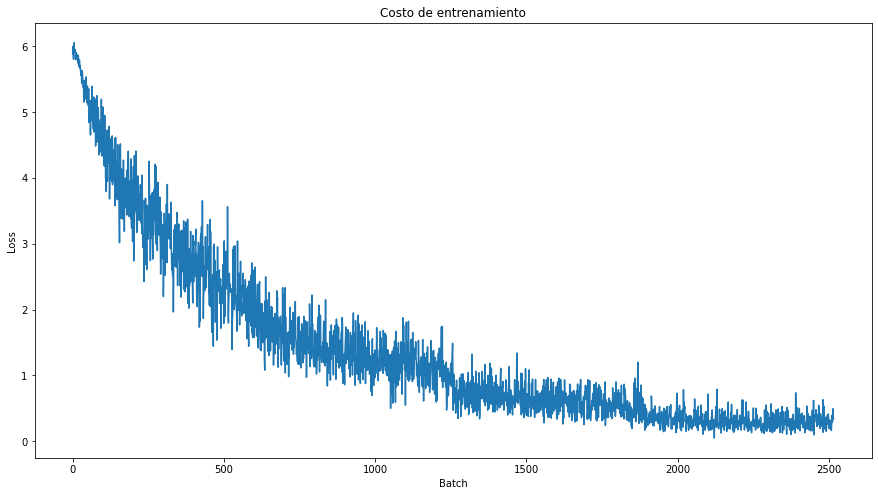

In [ ]:
from tqdm import trange

# Definimos una lista para guardar los valores del costo
train_loss_set = []

# Comenzamos a iterar
for e in trange(epochs, desc="Epoch"):  

  ## ENTRENAMIENTO:
  model.train()  
  for step, batch in enumerate(train_dataloader):
    
    # Enviamos las muestras al dispositivo
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Llevamos a cero los gradientes    
    optimizer.zero_grad()

    # Paso forward
    loss, _ = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    
    # Paso backward
    loss.backward() 

    # Actualizamos los parámetros y el scheduler
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()

    # Guardamos el valor del costo
    train_loss_set.append(loss.item())    

  ## EVALUACIÓN:
  model.eval()
  y_pred, y_test = [], []
  for batch in validation_dataloader:
    
    # Enviamos las muestras al dispositivo
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)

    # Predecimos 
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    
    # Guardamos los resultados de las predicciones
    label_pred = np.argmax(logits[0].detach().cpu().numpy(), axis=1).flatten()
    y_pred.append(label_pred)

    # Guardamos los resultados de las etiquetas
    label_ids = b_labels.numpy().flatten()
    y_test.append(label_ids)
  
  # Convertimos a numpy arrays
  y_test = np.concatenate(y_test)
  y_pred = np.concatenate(y_pred)
  
  # Obtenemos la puntuación
  scores = get_score(y_test,y_pred)

  # Visualizamos los resultados
  print('Finalizó epoch {}. Accuracy obtenida: {accuracy:.5f}. Balance accuracy obtenida: {balance accuracy:.5f}'.format(e,**scores))

# Gráfico del costo
plt.figure(figsize=(15,8))
plt.title("Costo de entrenamiento")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Por último, mostramos el código utilizado para generar el archivo a enviar a la [página oficial de la compentencia](https://metadata.fundacionsadosky.org.ar/competition/21/). El mismo no contiene nada nuevo en comparación con lo mencionado anteriormente.

In [ ]:
# Archivos donde extraer las preguntas y donde guardar los resultados:
input_filename = 'test.csv'
output_filename = 'results.csv'

# Cargamos el dataset:
df_test = pd.read_csv(input_filename)

# Tokenización:
questions = ["[CLS] {} [SEP]".format(question) for question in df_test['Pregunta']]
tokenizer = BertTokenizer.from_pretrained(beto_source, do_lower_case=False)
tokenized_questions = [tokenizer.tokenize(question) for question in questions]

# Padding de las oraciones:
max_len = 128 # Longitud máxima de las oraciones
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(question) for question in tokenized_questions],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")

# Máscaras de atención:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Datos de test:
batch_size = 32
test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


## PREDICCIÓN
model.eval()
y_pred = []
for batch in test_dataloader:

  # Llevamos las muestras al dispositivo:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  # Predecimos:
  with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
  label_pred = np.argmax(logits[0].detach().cpu().numpy(), axis=1).flatten()
  y_pred.append(label_pred)

# Guardamos las predicciones en el DataFrame original y lo convertimos a csv:
y_pred = np.concatenate(y_pred)
df_test['Pregunta'] = y_pred
df_test.to_csv(output_filename,index=False,header=False)

In [ ]:
!cat results.csv

0,303
1,303
2,311
3,129
4,258
5,229
6,134
7,96
8,304
9,311
10,303
11,342
12,132
13,251
14,168
15,39
16,265
17,344
18,342
19,86
20,30
21,77
22,223
23,80
24,303
25,239
26,355
27,279
28,293
29,39
30,225
31,354
32,117
33,226
34,39
35,288
36,147
37,184
38,215
39,308
40,1
41,284
42,267
43,251
44,342
45,316
46,59
47,96
48,42
49,350
50,80
51,223
52,46
53,96
54,192
55,239
56,129
57,225
58,96
59,1
60,334
61,185
62,223
63,39
64,38
65,192
66,106
67,1
68,268
69,99
70,147
71,293
72,41
73,228
74,325
75,311
76,248
77,161
78,76
79,50
80,191
81,39
82,248
83,219
84,212
85,223
86,198
87,138
88,132
89,206
90,181
91,265
92,59
93,337
94,1
95,32
96,293
97,39
98,31
99,41
100,3
101,65
102,138
103,96
104,115
105,178
106,292
107,96
108,200
109,261
110,167
111,36
112,0
113,132
114,219
115,132
116,248
117,135
118,329
119,316
120,125
121,200
122,282
123,248
124,41
125,39
126,223
127,267
128,293
129,258
130,286
131,157
132,68
133,39
134,293
135,68
136,49
137,293
138,293
139,129
140,146
141,95
142,44
143,99
144,129
14

# Conclusiones y posibles mejoras

En este trabajo pudimos probar la efectividad de utilizar el transformer BERT preentrenado para texto en español en una tarea que utiliza datos reales, utilizando procedimientos estándar en la selección de hiperparámetros. Los resultados parecen mostrar que el modelo realiza razonablemente bien la tarea, obteniendo, en el mejor de los experimentos ejecutados, un puntaje público de 0.85849 *balance accuracy*. Este puntaje obtuvo el 5to puesto en el *leaderboard* de la competencia al momento de finalización de la misma.

Durante el desarrollo del trabajo pudieron probarse diferentes variantes en el algoritmo de optimización Adam, así como el impacto de diferentes valores de *dropout* y funciones de activación en el modelo. Se obtuvo, sin embargo, que los mejores resultados se dieron para los valores predeterminados de la librería transformer (0.1 de probabilidad de *dropout* y función de activación *gelu*). Además, el desempeño del modelo BERT fue superior en todos los casos al de los demás transformers implementados, posiblemente debido a que éstos fueron preentrenados para muchos idiomas en simultáneo y no solamente para español. Este resultado requiere de una mayor validación experimental pero abre la puerta a una investigación comparativa entre modelos multilingües y modelos entrenados en un idioma específico (que, por supuesto, excede los objetivos de la presente competencia).

Además de los modelos mencionados anteriormente, la tarea se intentó resolver mediante los modelos de clasificación Naive Bayes multinomial y SVM lineal. Estos modelos se utilizan generalmente como base comparativa con respecto a los nuevos modelos propuestos en un trabajo y suelen combinarse con métodos de reponderamiento como PPMI o TF-IDF, por lo cual solo mostramos los resultados para el mejor caso en cada uno de ellos:

| Puntaje          | Naive Bayes | LinearSVM |
|------------------|-------------|-----------|
| Accuracy         | 0.760       | 0.745     |
| Balance Accuracy | 0.653       | 0.523     |

Como puede observarse, el modelo BETO se comportó significativamente mejor que estos dos modelos. Notemos, sin embargo, que esta comparación no es del todo justa, dado que para que BETO funcione correctamente, tiene que preentrenarse con un corpus mucho más extenso que el provisto para la competencia. Sin embargo, la metodología actual para resolver este tipo de tareas incluye muchas veces técnicas de [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) como las que utilizan los transformers.

Por otro lado, consideramos que, con más recursos y tiempo, el modelo podría haber obtenido mejores resultados. A continuación proponemos algunas mejoras a este trabajo:

* Recolectar nuevas muestras, sobre todo de las clases menos pobladas. Dado que el mejor resultado público obtenido por los participantes fue 0.88300 es probable que el error bayesiano esté cerca de este valor (el cual difiere menos del 3% al obtenido). En ese caso de que esto se cierto, la única posibilidad de mejorar significativamente el desempeño de cualquier modelo sería obteniendo más muestras (ya sean sintéticas o reales), dado que este error no depende del modelo que se utilice.

* Utilizar datos en español con dialecto argentino para realizar un ajuste fino del modelo de lenguaje de BETO antes de realizar el ajuste para clasificación. Esto puede influir significativamente en el resultado ya que las muestras de entrenamiento están escritas con este dialecto, mientras que las usadas para entrenar a BETO son, en su mayoría, español de España. Además, este proceso no requiere recursos muy costosos dado que es sencillo encontrar muestras de este tipo, pero requiere tiempo de relevar los datos y por eso no se implementó en la presente competencia.

* Con una cantidad de recursos suficientemente grande, sería posible entrenar un modelo similar, pero de más capas y cabezas de atención, que el utilizado en la competencia. Esto suele tener mejoras muy significativas en el desempeño del modelo, tal como se muestra en [Devlin et al.,2018](https://arxiv.org/abs/1810.04805).

* Realizar una búsqueda más exhaustiva de hiperpámetros. Por una cuestión de tiempo, sólo pudieron hacerse pruebas variando la probabilidad de dropout y la función de activación entre las capas lineales. Cabe recordar que cada entrenamiento de estos modelos lleva horas de procesamiento computacional, aún con hardware optimizado (GPUs).

* Probar diferentes algoritmos de optimización que incluyan algún tipo de regularización extra, además del dropout. El algoritmo Adam es bastante estándar para este tipo de arquitecturas y suele ser el más rápido de los que su utilizan comúnmente. Sin embargo, no hay motivos para suponer que es el mejor para esta tarea en particular.

* Utilizar una arquitectura más elaborada en el decoder, en lugar de una única capa lineal. Esto no es algo prioritario, puesto que puede contraer problemas adicionales, pero con más tiempo podría haberse hecho la prueba.

* Probar diferentes funciones de costo. Dado que lo que se desea maximizar es la métrica *balance accuracy*, podría haberse probado un función `cross-entropy` ponderada según las frecuencias de relativas de cada clase. Esto es una prueba válida, pero supone que existe una distribución similar de los datos en ambos conjuntos de muestras (train y test).

* Realizar un procesamiento previo de las muestras de entrenamiento. Este proceso no se hizo porque la calidad gramatical de las oraciones del archivo `training.csv` era bastante buena, a diferencia de otras aplicaciones como análisis de tweets. Además, el procesamiento excesivo del texto de entrenamiento suele traer la desventaja de que se pierde información léxica de las oraciones, por lo que no siempre suele implicar una mejora.

